In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pprint
import pickle
import json
import os, sys
os.chdir("../")
sys.path.append('src/')
from util import *
from train import train_instances, best_generalization_agent

In [30]:
def plot_line(value, label, color, ax, fontsize):
    ax.text(5, value, label, {"fontsize": fontsize})
    ax.axhline(y=value, color=color, linestyle="-")
    
def process_df(df, window_size=30, base=20):
    df["best transitions"] = df["expanded transitions"].cummin()
    df["rounded idx"] = df["idx"].apply(lambda idx : idx // base * base if idx < 100 else 100 - base)
    df = df.loc[df["idx"] <= (df["rounded idx"].max()-1)*window_size]
    if len(df) < 30:
        window_size = 10
    if "training steps" not in df.columns:
        df["training steps"] = df["idx"]*50000
    df["mean transitions"] = list(np.convolve(list(df["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
    #df["expanded transitions"] = df["expanded transitions"].fillna(df["expanded transitions"].max()+10)
    df["instance"] = df.apply((lambda r: (r["problem"], r["n"], r["k"])), axis=1)
    df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["k"]][r["n"]], axis=1)
    df["expanded transitions / total"] = df["expanded transitions"] / df["total transitions"]
    df["mean transitions / total"] = df["mean transitions"] / df["total transitions"]
    return df

def read_training_data(problem, file, multiple):
    with open("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/training_data.pkl", "rb") as f:
        training_data, agent_params, env_params = pickle.load(f)    
    df = pd.DataFrame(training_data)
    df["idx"] = df["training steps"] // 10000
    df["case"] = file
    df["problem"] = problem
    if multiple:
        instances = train_instances(problem)
        df["n"] = df.apply(lambda r: instances[int(r["idx"]) % len(instances)][1], axis=1)
        df["k"] = df.apply(lambda r: instances[int(r["idx"]) % len(instances)][2], axis=1)
    else:
        df["n"] = 2
        df["k"] = 2
        df["problem"] = problem
    return df

def all_solved_instances(dfs):
    instances = []
    for n in range(1, 16):
        for k in range(1, 16):
            good = True
            for df in dfs:
                if ((df["n"] == n) & (df["k"] == k)).sum() < 100:
                    good = False
                    break
            if good:
                instances.append((n, k))
    return instances

# Comparing transitions

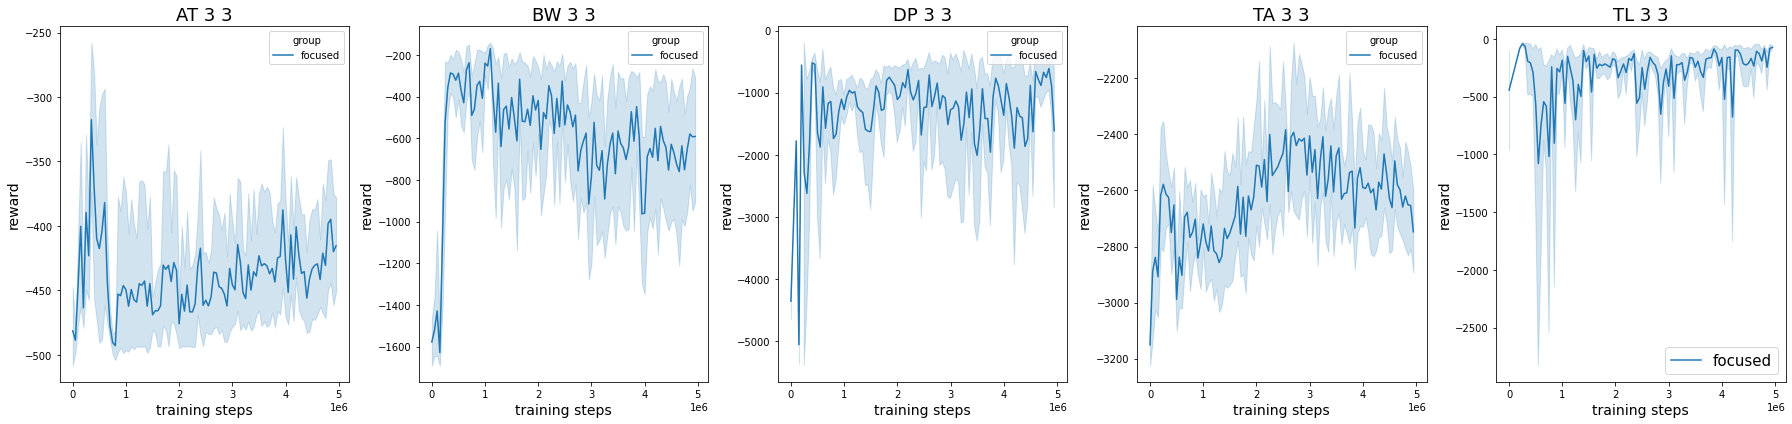

In [14]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10) 

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

n2, k2 = 3, 3
if n2 == 3:
    problems = [p for p in problems if p != "CM"]

files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L", "5mill_C", "5mill_SL20", "5mill_JE", "5mill_JE20"]
old_files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L"]
files = ["5mill_RA", "5mill_L", "5mill_C", "5mill_SL20", "5mill_JE20", "RR"]
files = ["5mill_JE20", "5mill_JE_D", "5mill_RR10k_D", "5mill_RR10k_D_N", "5mill_RR10k_N"]
files = ["5mill_JE20", "5mill_JE_NORA", "5mill_RR10k_NORA", "5mill_RR10k_D_N", "5mill_RR10k_NORA_1"]
files = ["focused_1", "multiple_1", "no_TB"]
files = [(f, "focused") for f in ["focused_1", "focused_2", "focused_4",
                                  "focused_5", "focused_6", "focused_7", "5mill_JE_NORA"]]

#files += [("testing", "3step"), ("3stepRRu", "3stepRRu")]

#files = [("focused_1", "focused_1"), ("3stepRRu4k", "3stepRRu4k")]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    problem = problems[i]
    dfs = []
    for n, k, file, group  in [(2, 2, f, group) for f, group in files]:
        if file in old_files:
            df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/"+filename([problem, n2, k2])+".csv")
        else:
            df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
            
        df = process_df(df)
        df["case"] = filename([n, k, file])
        df["group"] = group
        
        dfs.append(df)
        
        
    df = pd.concat(dfs, ignore_index=True)
    #df = df.loc[(df["n"]==df["k"])&((df["n"]==2) | (df["n"]==3))]
    df = df.loc[(df["n"]==n2)&(df["k"]==k2)]
    
    df["reward"] = -df["expanded transitions"]
    #sns.lineplot(data=df, x="training steps", y="reward", estimator=np.max, ax=axs[i], ci=None)
    #sns.lineplot(data=df, x="training steps", y="reward", estimator=np.min, ax=axs[i], ci=None)
    sns.lineplot(data=df, x="training steps", y="reward", ax=axs[i], hue="group")
    
    #ra = ra_results["expanded transitions", problems[i]][n2][k2]
    #print(len(random_results_small[(problems[i], n2, k2)]))
    #random_min = min(random_results_small[(problems[i], n2, k2)])
    #random_mean = np.mean(random_results_small[(problems[i], n2, k2)])
    #plot_line(-ra, "RA", "red", axs[i], 15)
    #plot_line(-random_min, "Random max", "green", axs[i], 15)
    #plot_line(-random_mean, "Random mean", "green", axs[i], 15)
    #if i != len(problems)-1:
    #    axs[i].get_legend().remove()
    axs[i].set_title(" ".join([problem, str(n2), str(k2)]), fontdict={"fontsize": 18})

handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, prop={'size': 15}, loc="lower right")
plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg")
plt.show()

## Plotting training performance

In [ ]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def plot_training_perf(files, problem, ax, max_steps=5000000, factor=1):
    dfs = []
    for file, group in files:
        try:
            print("Reading", file)
            multiple = "RR" in group
            df = read_training_data(problem, file, multiple)
            df = df.loc[df["training steps"] <= max_steps]
            #df = df.loc[(df["n"] == 2) & (df["k"] == 2)]
            df["multiple"] = multiple
            df["run"] = file
            df["group"] = group
            
            df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["k"]][r["n"]], axis=1)
            #df["reward"] = -df["expanded transitions"] / factor
            #df["training steps"] = df["training steps"] // 100000 * 100000
            #group_means = df.groupby("training steps")["reward"].mean()
            #df["reward"] = df.apply(lambda row: group_means[row["training steps"]], axis=1)
            window_size = 100
            df['norm transitions'] = df.groupby('total transitions')["expanded transitions"].apply(lambda x: (x - x.mean()) / x.std())
            df["mean transitions"] = list(np.convolve(list(df["norm transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
            dfs.append(df)
        except OSError as e:
            print("Couldn't read", file, "for problem", problem)
            print(e)
    
    df = pd.concat(dfs, ignore_index=True)
    print("Plotting")
    df["reward"] = -df["mean transitions"] / factor
    sns.lineplot(data=df, x="training steps", y="reward", ax=ax, hue="group", alpha=0.6)
    
def plot_ra_and_random(files, problem, n, k, ax):
    ra = ra_results["expanded transitions", problem][n][k]
    random_min = min(random_results_small[(problem, n, k)])
    random_mean = np.mean(random_results_small[(problem, n, k)])
    plot_line(-ra, "RA", "red", ax, 15)
    plot_line(-random_min, "Random max", "green", ax, 15)
    plot_line(-random_mean, "Random mean", "green", ax, 15)
    
#def plot_n_k(files, problem, n, k, ax, max_steps=5000000, factor=1):
#    dfs = []
#    for file, multiple in files:
#        df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
#        df = df.loc[(df["n"]==n)&(df["k"]==k)]
#        df = process_df(df)
#        df = df.loc[df["training steps"] <= max_steps]
#        dfs.append(df)
#    df = pd.concat(dfs, ignore_index=True)
#    #df["rounded training steps"] = df["training steps"] // 1000 * 1000
#    df["reward"] = -df["expanded transitions"] / factor
#    sns.lineplot(data=df, x="training steps", y="reward", ax=ax)
    
files = [(f, "focused") for f in ["focused_1", "focused_2", "focused_3", "focused_4",
                                  "focused_5", "focused_6", "focused_7"]]

files = [("focused_1", "focused")]
files += [("testing", "3step"), ("3stepRRu", "3stepRRu")]

problems = ["AT", "BW"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    df = plot_training_perf(files, problems[i], axs[i], max_steps=5000000, factor=1)
    
    #mean = df.loc[~df["multiple"]]["expanded transitions"].mean()
    #std = df.loc[~df["multiple"]]["expanded transitions"].std()
    
    #plot_n_k(files, problems[i], 3, 3, axs[i], max_steps=500000, factor=total_3_3)
    #plot_ra_and_random(files, problems[i], 2, 2, axs[i])
    axs[i].get_legend().remove()
    if i != 0:
        axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(problems[i], fontdict={"fontsize": 18})

handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, prop={'size': 15}, loc="lower right")
plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg")

In [ ]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 


#files = [(f, False) for f in ["focused_1"]]#, "focused_2", "focused_3", "focused_4",
#                                  "focused_5", "focused_6", "focused_7"]]

files = [("focused_1", False), ("pytorch2", False)]
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#problems = ["AT", "BW", "CM"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    dfs = []
    for file, multiple in files:
        try:
            df = read_training_data(problems[i], file, multiple)
            df = process_df(df, window_size=50)
            df["multiple"] = multiple
            df['norm transitions'] = df.groupby('total transitions')["expanded transitions"].apply(lambda x: (x - x.mean()) / x.std())
            dfs.append(df)
        except OSError as e:
            print("Couldn't read", file, "for problem", problems[i])
            print(e)
        
    df = pd.concat(dfs, ignore_index=True)
    #print(list(df["total transitions"]))
    df["reward"] = -df["mean transitions"]
    print(df["reward"].max())
    df["normalized reward"] = -df["norm transitions"]
    sns.lineplot(data=df, x="training steps", y="reward", ax=axs[i])
    
    mean = df.loc[~df["multiple"]]["expanded transitions"].mean()
    std = df.loc[~df["multiple"]]["expanded transitions"].std()
    
    ra = ra_results["expanded transitions", problems[i]][2][2]
    random_min = min(random_results_small[(problems[i], 2, 2)])
    random_mean = np.mean(random_results_small[(problems[i], 2, 2)])
    #ra, random_min, random_mean = tuple((np.array([ra, random_min, random_mean]) - mean) / std)
    plot_line(-ra, "RA", "red", axs[i], 15)
    plot_line(-random_min, "Random max", "green", axs[i], 15)
    plot_line(-random_mean, "Random mean", "green", axs[i], 15)
    if i != len(problems)-1:
        axs[i].get_legend().remove()
    #if i != 0:
    #    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(problems[i], fontdict={"fontsize": 18})
handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, prop={'size': 15}, loc="lower right")
plt.tight_layout()
#plt.savefig("experiments/figures/NORA/training_reward_eps.jpg")

## Plot solved

In [ ]:
problems = ["AT", "BW"]#, "CM", "DP", "TL"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

files1 = ["5mill_C", "5mill_SL", "5mill_SL20", "5mill_JE", "5mill_JE20"]
files2 = ["5mill_JE20", "5mill_RR10k_D", "RR", "5mill_RR10k_D_N", "5mill_RR10k_N"]
files3 = ["5mill_JE20", "5mill_JE_NORA", "5mill_RR10k_NORA", "5mill_RR10k_D_N", "5mill_RR10k_NORA_1"]
files4 = ["5mill_RR10k_NORA", "5mill_RR10k_NORA_1"]
files = ["focused_1", "focused_2", "multiple_1", "multiple_2", "no_TB"]#, "5mill_JE20", "5mill_RR10k_D_N"]
#files = {f for f in files1+files2+files3+files4+files5}
files = ["focused_1", "prop", "rmsprop"]

files1 = ["focused_1", "focused_2", "focused_3", "5mill_JE_NORA", "focused_4", "focused_5", "focused_6", "focused_7"]
files2 = ["multiple_1", "multiple_2", "5mill_RR10k_NORA"]
files3 = ["visits6432"]
files4 = ["focused_4"]

files = [(f, "focused") for f in files1]# + [(f, "multiple") for f in files2]# + [(f, "visits") for f in files3]

files = [(f, "focused") for f in files1]# + [(f, "visits6432") for f in files3]

files = files + [("testing", "3step"), ("3stepRRu", "3stepRRu")]
#files = [("visits", "visits")]
#files = [("focused_1", "focused"), ("pytorch2", "deep")]
metric = "solved"
n, k = 2, 2
for i in range(len(problems)):
    problem = problems[i]
    dfs = []
    dfs_all = []
    for file, group in files:
        try:
            df_all = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/generalization_all.csv")
            df_all["file"] = file
            df_all = df_all.dropna(subset=["expanded transitions"])
            dfs_all.append(df_all)
            
            df = []
            for x, cant in dict(df_all["idx"].value_counts()).items():
                df.append({"idx": x, "solved": cant})
            df = pd.DataFrame(df)
            df.sort_values(by="idx", inplace=True)
            df["file"] = file
            df["group"] = group
            window_size = 10
            df["max solved"] = df["solved"].cummax()
            #print(problems[i], file, list(df.loc[df["solved"] == df["solved"].max()]["idx"]))
            best_idx = best_generalization_agent(problems[i], file)
            #print(problems[i], file, best_idx)
            #print(problems[i], file, list(df.loc[df["idx"] == best_idx]["solved"])[0])
            df["mean solved"] = list(np.convolve(list(df["solved"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
            dfs.append(df)
        except BaseException as e:
            print(problem, "Couldn't read", file)
    df = pd.concat(dfs, ignore_index=True)
    df_all = pd.concat(dfs_all, ignore_index=True)
    
    df_ra = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/RA_5s_15.csv")
    solved_ra = len(list(df_ra["expanded transitions"].dropna()))
    
    df_random = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/random_5s.csv")
    solved_random = len(list(df_random["expanded transitions"].dropna())) / 20
    
    #print(df_random.columns)
    #print(df_random.dropna(subset=["expanded transitions"])["expanded transitions"])
    #print(problems[i], list(df_random.dropna()))
    
    plot_line(solved_ra, "RA", "red", axs[i], 15)
    plot_line(solved_random, "Random", "green", axs[i], 15)
    
    #sns.lineplot(data=df, x="idx", y=metric, ax=axs[i], hue="group", estimator=None, units="file")
    sns.lineplot(data=df, x="idx", y=metric, ax=axs[i], hue="group")
    axs[i].set_title(problem)
    #axs[i].set_ylim((0, max(solved_ra, df[metric].max())*1.1))
plt.tight_layout()

plt.savefig("experiments/figures/tmp.jpg", dpi=500)
plt.show()

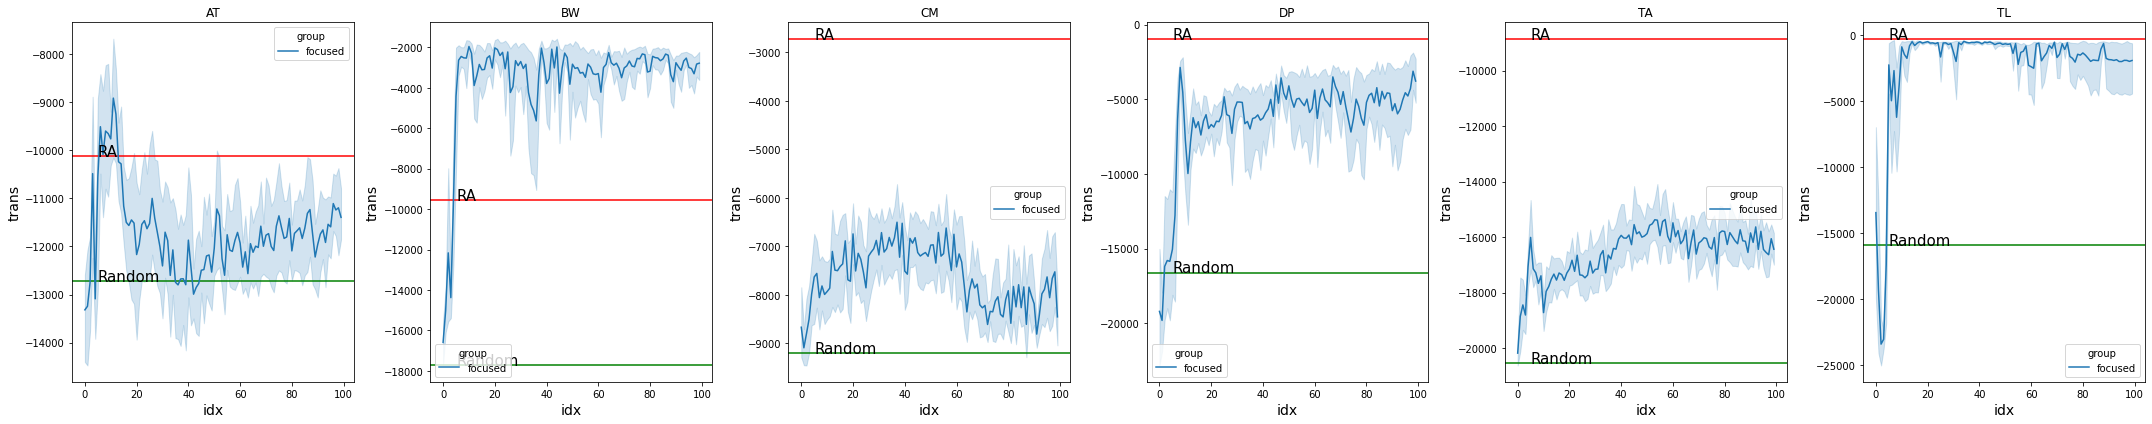

In [38]:
def all_solved_instances(dfs):
    instances = []
    for n in range(1, 16):
        for k in range(1, 16):
            good = True
            for df, cant in dfs:
                if ((df["n"] == n) & (df["k"] == k)).sum() < cant:
                    good = False
                    break
            if good:
                instances.append((n, k))
    return instances

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

files1 = ["focused_1", "focused_2", "focused_3", "5mill_JE_NORA", "focused_4", "focused_5", "focused_6", "focused_7"]

files = [(f, "focused") for f in files1]

# files = files + [("testing", "3step"), ("3stepRRu", "3stepRRu")]

metric = "trans"
n, k = 2, 2
for i in range(len(problems)):
    problem = problems[i]
    dfs_all = []
    for file, group in files:
        df_all = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/generalization_all.csv")
        df_all["file"] = file
        df_all = df_all.dropna(subset=["expanded transitions"])
        dfs_all.append(df_all)

    df_ra = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/RA_5s_15.csv")
    df_ra = df_ra.dropna(subset=["expanded transitions"])
    df_random = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/random_5s.csv")
    df_random = df_random.dropna(subset=["expanded transitions"])
    
    instances = all_solved_instances([(df, 100) for df in dfs_all]+[(df_ra, 1)]+[(df_random, 20)])
    
    df_ra["instance"] = df_ra.apply(lambda r: (r["n"], r["k"]), axis=1)
    df_ra = df_ra.loc[df_ra["instance"].isin(instances)]
    df_random["instance"] = df_random.apply(lambda r: (r["n"], r["k"]), axis=1)
    df_random = df_random.loc[df_random["instance"].isin(instances)]
    
    dfs = []
    j = 0
    for file, group in files:
        df_all = dfs_all[j]
        df_all["instance"] = df_all.apply(lambda r: (r["n"], r["k"]), axis=1)
        df_all = df_all.loc[df_all["instance"].isin(instances)]
        df = []
        
        for cidx, dfg in df_all.groupby("idx"):
            df.append({"idx": cidx, "trans": -dfg["expanded transitions"].sum()})
        
        df = pd.DataFrame(df)
        df.sort_values(by="idx", inplace=True)
        df["file"] = file
        df["group"] = group

        window_size = 10
        df["min trans"] = df["trans"].cummax()
        df["mean trans"] = list(np.convolve(list(df["trans"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
        dfs.append(df)
        j += 1
    df = pd.concat(dfs, ignore_index=True)
    df_all = pd.concat(dfs_all, ignore_index=True)
    
    trans_ra = -df_ra["expanded transitions"].dropna().sum()
    trans_random = -df_random["expanded transitions"].dropna().sum() / 20
    
    #print(df_random.columns)
    #print(df_random.dropna(subset=["expanded transitions"])["expanded transitions"])
    #print(problems[i], list(df_random.dropna()))
    
    plot_line(trans_ra, "RA", "red", axs[i], 15)
    plot_line(trans_random, "Random", "green", axs[i], 15)
    
    #sns.lineplot(data=df, x="idx", y=metric, ax=axs[i], hue="group", estimator=None, units="file")
    sns.lineplot(data=df, x="idx", y=metric, ax=axs[i], hue="group")
    axs[i].set_title(problem)
    #axs[i].set_ylim((0, max(solved_ra, df[metric].max())*1.1))
plt.tight_layout()

plt.savefig("experiments/figures/tmp.jpg", dpi=500)
plt.show()

## Detailed analysis of multiple instances learning

In [ ]:
file = "multiple_1"
multiple = True

problem = "BW"

df = read_training_data(problem, file, multiple)
df = df.loc[(df["n"] == 2) & (df["k"] == 2)]
trans = list(df["expanded transitions"])
idx = list(df["idx"])
steps = list(df["training steps"])
trans_per_batch = [[] for _ in range(min(idx), max(idx)+1)]
for i in range(len(steps)):
    trans_per_batch[idx[i]].append(trans[i])

df = []
for i in range(len(trans_per_batch)):
    for j in range(len(trans_per_batch[i])):
        df.append({"trans": trans_per_batch[i][j], "batch": i, "rel idx": j})
df = pd.DataFrame(df)
sns.lmplot(data=df, x="rel idx", y="trans", hue="batch")
plt.show()
#for idx in df["idx"].unique():
#    df
#sns.scatterplot(data=df, x="training steps", y="expanded transitions")

## 15 15 Generalization

In [ ]:
def get_comp_solved_df(agent, ra):
    only_ra = ((agent == float("inf")) & (ra != float("inf")))
    only_agent = ((agent != float("inf")) & (ra == float("inf")))
    both = ((agent != float("inf")) & (ra != float("inf")))
    
    return only_ra*1 + only_agent*2 + both*(3*(agent > ra) + 4*(agent == ra) + 5*(agent < ra))

metric = "expanded transitions"
#df1 = lambda problem: df_agent(problem, "all_ra_afterfix_15.csv")
df1 = lambda problem: df_agent(problem, "3stepRRu/all.csv")
#df1 = lambda problem: df_agent(problem, "visits/all.csv", metric=metric)
#df1 = lambda problem: df_agent(problem, "multiple_all/all.csv", metric=metric)
#df1 = lambda problem: df_agent(problem, "5mill_RR10k_NORA/all.csv", metric=metric)
#df1 = lambda problem: df_agent(problem, "RR/all.csv")
#df1 = lambda problem: df_agent(problem, "all_e_15.csv")
#df1 = lambda problem: df_agent(problem, "all_random1.csv")
#df1 = lambda problem: df_agent(problem, "all_open_15.csv")
#df1 = lambda problem: df_comp(problem, ra_results)


#df2 = lambda problem: df_agent(problem, "all_ra_old_15_old.csv")
df2 = lambda problem: df_agent(problem, "focused_1/all.csv")
#df2 = lambda problem: df_comp(problem, random_results)
#df2 = lambda problem: df_comp(problem, ra_results, metric=metric)
#df2 = lambda problem: df_comp(problem, monolithic_results, metric=metric)

#print(df1("DP"))
#print(df2("DP"))

problems = ["AT", "AT"]#, "CM", "DP", "TL"]
#problems = ["DP", "TA", "BW"]
#problems = ["AT", "BW", "DP", "CM"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))
s1 = []
s2 = []
df1w = []
df2w = []
for i in range(len(problems)):
    
    grey = "#d0e1d4"
    red = "#ed6a5a"
    blue = "#008bf8"
    green = "#08a045"
    green1 = "#adc178"
    green2 = "#045c27"
    df1p = df1(problems[i])
    df2p = df2(problems[i])
    s1.append(np.sum([df1p[n][k] != float("inf") for n in range(1, 16) for k in range(1, 16)]))
    s2.append(np.sum([df2p[n][k] != float("inf") for n in range(1, 16) for k in range(1, 16)]))
    df1w.append(np.sum([df1p[n][k] < df2p[n][k] for n in range(1, 16) for k in range(1, 16)]))
    df2w.append(np.sum([df2p[n][k] < df1p[n][k] for n in range(1, 16) for k in range(1, 16)]))
    sns.heatmap(data=get_comp_solved_df(df1(problems[i]), df2(problems[i])), cmap=[grey, red, blue, green, green1, green2], vmin=0, vmax=5, ax=axs[i], cbar=False)
    
    print(problems[i], len(train_instances(problems[i])))
    for problem, n, k in train_instances(problems[i]):
        axs[i].text(k - 0.5, n - 0.5, "X",
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
    
    axs[i].invert_yaxis()
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
#plt.savefig("experiments/figures/NORA/focused_5_vs_RA.jpg", dpi=200)
plt.show()
print(s1, np.sum(s1))
print(s2, np.sum(s2))
print(df1w, np.sum(df1w))
print(df2w, np.sum(df2w))


## 15 15 transitions

AT
BW
CM
DP
TA
TL


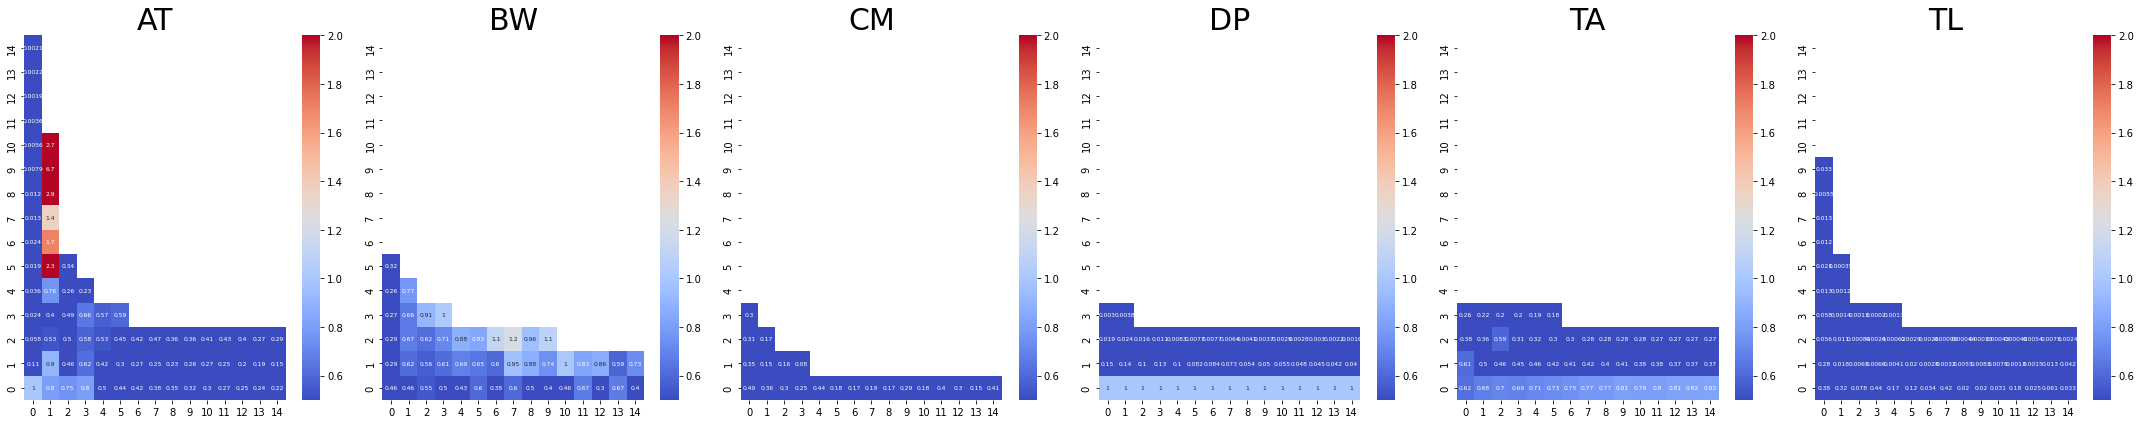

In [8]:
vmin = 0.5
vmax = 2

def best_transitions_agent(df_all):
    instances = all_solved_instances([df_all])
    
    df_all["instance"] = df_all.apply(lambda r: (r["n"], r["k"]), axis=1)
    df_all = df_all.loc[df_all["instance"].isin(instances)]
    return min([(dfg["expanded transitions"].sum(), cidx) for cidx, dfg in df_all.groupby("idx")])[1]

def df_agent_5s(problem, file):
    df_all = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
    df_all["file"] = file
    df_all = df_all.dropna(subset=["expanded transitions"])
    idx = best_transitions_agent(df_all)
    print(problem)
    print(idx)
    print(best_generalization_agent(problem, file))
    df_agent = df_all.loc[df_all["idx"] == idx]
    df_agent = fill_df(df_agent, 15)
    return df_agent.pivot("n", "k", "expanded transitions")

def get_heatmap_value(a, r):
    if r == float("inf") and np.all([ai == float("inf") for ai in a]):
        return np.nan
    elif r == float("inf"): # agent solved at least once and ra didnt
        return vmin
    elif not np.any([ai == float("inf") for ai in a]): # both always solved
        return np.mean([ai / r for ai in a])
    elif np.all([ai == float("inf") for ai in a]): 
        return vmax # agent never solved and ra solved
    else: # agent solved sometimes and ra solved
        return np.mean([ai / r for ai in a if ai != float("inf")])

def get_heatmap_value_only_solved(a, r):
    if r == float("inf") or np.any([ai == float("inf") for ai in a]):
        return np.nan
    else:
        return np.mean([ai / r for ai in a])
    
def get_df(agent_dfs, ra):
    #print(agent)
    #print(ra)
    m = np.zeros(shape=(15, 15))
    for n in range(15):
        for k in range(15):
            r = ra[k+1][n+1]
            a = [df[k+1][n+1] for df in agent_dfs]
            m[n, k] = get_heatmap_value_only_solved(a, r)
    return m
    
    only_ra = ((agent == float("inf")) & (ra != float("inf")))
    only_agent = ((agent != float("inf")) & (ra == float("inf")))
    both = ((agent != float("inf")) & (ra != float("inf")))
    
    cases = 0
    return both * (agent / ra) + (~both) * (-1)
    return both * (agent / ra) + cases#only_ra * min(agent / ra) + only_agent * min(agent / ra)
    #return only_ra*1 + only_agent*2 + both*(3*(agent > ra) + 4*(agent == ra) + 5*(agent < ra))

metric = "expanded transitions"

agent_files = ["5mill_JE_NORA", "focused_1", "focused_2", "focused_4",
               "focused_5", "focused_6", "focused_7"]

#agent_files = ["5mill_RR10k_NORA", "multiple_1", "multiple_2"]
#agent_files = ["testing"]

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))
for i in range(len(problems)):
    print(problems[i])
    #dfs_agent = [df_agent(problems[i], file+"/all.csv", metric=metric) for file in agent_files]
    #dfs_agent = [df_agent_5s(problems[i], file) for file in agent_files]
    dfs_agent = [df_comp(problems[i], ra_results, metric=metric)]
    #df_ra = df_comp(problems[i], ra_results, metric=metric)
    df_ra = df_comp(problems[i], random_results, metric=metric)
    #df_ra = df_agent(problems[i], "3stepRRu/all.csv", metric=metric)
    data = get_df(dfs_agent, df_ra)
    sns.heatmap(data=data, 
                cmap="coolwarm", #sns.cm.rocket_r#[grey, red, blue, green, green1, green2], 
                annot=True, annot_kws={"size":6},
                ax=axs[i], cbar=True, vmin=0.5, vmax=2)
    
    axs[i].invert_yaxis()
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg", dpi=200)
plt.show()


## Solved table

In [ ]:
def solved_metric(df, factor=1):
    return len(df["expanded transitions"].dropna()) / factor

def mean_trans_metric(df, factor=1):
    df["total"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["k"]][r["n"]], axis=1)
    return (df["expanded transitions"] / df["total"]).mean()

multiple = (["5mill_RR10k_NORA", "multiple_1", "multiple_2"], "multiple")
focused = (["5mill_JE_NORA", "focused_1", "focused_2", "focused_3", "focused_4", "focused_5", "focused_6", "focused_7"], "focused")

filegroups = [focused]
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

approaches = ["focused", "RA", "random"]
timeout = "10m"

metric = solved_metric
results = {problem: {ap: [] for ap in approaches} for problem in problems+["all", "all (AT, BW, DP, TA)"]}
for i in range(len(problems)):
    for files, name in filegroups:
        if name == "multiple" and problems[i] not in ["AT", "TA", "BW", "DP"]:
            continue
        for file in files:
            if timeout == "5s":
                df = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+file+"/generalization_all.csv")
                best_idx = best_generalization_agent(problems[i], file)
                df = df.loc[df["idx"] == best_idx]
            else:
                df = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+file+"/all.csv")
            results[problems[i]][name].append(metric(df))
    
    file_random = "random_5s" if timeout == "5s" else "all_random"
    random_n = 20 if timeout == "5s" else 1
    df_random = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+file_random+".csv")
    results[problems[i]]["random"].append(metric(df_random, factor=random_n))
    
    file_ra = "RA_5s_15" if timeout == "5s" else "all_ra_afterfix_15"
    df_ra = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+file_ra+".csv")
    results[problems[i]]["RA"].append(metric(df_ra))

for approach in approaches:
    n = len(results["AT"][approach])
    if approach != "multiple":
        results["all"][approach] = [0 for j in range(n)]
        for j in range(n):
            for problem in problems:
                results["all"][approach][j] += results[problem][approach][j]
    
            
    results["all (AT, BW, DP, TA)"][approach] = [0 for j in range(n)]
    for j in range(n):
        for problem in ["AT", "BW", "DP", "TA"]:
            results["all (AT, BW, DP, TA)"][approach][j] += results[problem][approach][j]

In [ ]:
from scipy.stats import ttest_1samp, wilcoxon

for problem in problems+["all"]:
    print(problem)
    random = results[problem]["random"][0]
    ra = results[problem]["RA"][0] / random
    agent = np.array(results[problem]["focused"]) / random
    print(np.round(np.mean(agent), 2), np.round(ra, 2), ttest_1samp(agent-ra, 0, alternative="two-sided").pvalue)
    
# p-valores con ttest:
# AT significativamente mejor.
# BW significativamente mejor.
# CM significativemente peor.
# DP significativemente peor.
# TA iguales.
# TL iguales.
# General: iguales! (por muy poquito jaja, p=0.059)
# Faltaría chequear la validez de este test.

In [ ]:
rows = [{"approach": ap} for ap in approaches[:-1]]
for problem in problems+["all"]:#, "all (AT, BW, DP, TA)"]:
    for j in range(len(approaches)-1):
        r = results[problem][approaches[j]]
        print(problem, approaches[j], r)
        r = np.array(r) / results[problem]["random"][0]
        mean = np.round(np.mean(r), 2)
        std = np.round(np.std(r), 2)
        if std > 0.0001:
            rows[j][problem] = str(mean) + " ± " + str(std)
        else:
            rows[j][problem] = str(mean)

dft = pd.DataFrame(rows)

print(dft.to_latex(index=False, float_format="%.2f"))

In [ ]:
for problem in problems:
    ag = results[problem]["focused"]
    ra = results[problem]["focused"]
    

## 15 15 Generalization average

In [ ]:
def get_max_n_curve(df):
    max_n = []
    for k in range(1, 16):
        max_n.append(np.sum(df[k] != float("inf")))
    return pd.DataFrame({"k": np.arange(1, 16), "max n": max_n})
    

metric = "expanded transitions"

filegroups = [(["5mill_RR10k_NORA", "multiple_1"], "multiple"), (["5mill_JE20", "focused_1"], "focused")]

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    dfs = []
    for files, name in filegroups:
        for file in files:
            try:
                df = df_agent(problems[i], file+"/all.csv", metric=metric)
                dfs.append(get_max_n_curve(df))
                dfs[-1]["file"] = file
                dfs[-1]["approach"] = name
            except:
                pass
    df_random = get_max_n_curve(df_comp(problems[i], random_results, metric=metric))
    df_random["approach"] = "random"
    df_ra = get_max_n_curve(df_comp(problems[i], ra_results, metric=metric))
    df_ra["approach"] = "RA"
    
    df = pd.concat(dfs+[df_ra, df_random], ignore_index=True)
    
    sns.lineplot(data=df, x="k", y="max n", hue="approach", ax=axs[i], ci=None, marker="o")
    axs[i].set_ylim((0, 16))
    axs[i].set_xlim((0, 16))
    axs[i].set_title(problems[i])

plt.tight_layout()
#plt.savefig("experiments/figures/NORA/NORA_vs_RA.jpg", dpi=200)
plt.show()

## Solved instances vs expanded transitions

In [ ]:
n, k = 3, 3
for problem in ["TL"]:#, "BW", "CM", "DP", "TA", "TL"]:
    print(problem)
    file = "focused_1"

    df_all = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
    df = []
    for x, cant in dict(df_all["idx"].value_counts()).items():
        df.append({"idx": x, "solved": cant})
    df = pd.DataFrame(df)
    df.sort_values(by="idx", inplace=True)

    solved = list(df["solved"])
    trans = list(-df_all.loc[(df_all["n"] == n) & (df_all["k"] == k)]["expanded transitions"])

    sns.regplot(x=trans, y=solved)
    plt.show()

# Comparing avg Q

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#problems = ["AT", "BW", "DP", "TA"]
n, k = 2, 2
files = ["5mill_RA", "5mill_L", "5mill_C", "5mill_SL20", "5mill_JE20", "5mill_JE_NORA"]
#files = ["5mill_JE20", "RR", "5mill_RR10k_D", "5mill_RR10k_N", "5mill_RR10k_D_N"]
files = ["5mill_JE20", "focused_1", "no_TB", "visits"]
files = ["focused_1", "visits"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    dfs = []
    for file in files:
        dfs.append(pd.read_csv("experiments/results/"+filename([problems[i], n, k])+"/"+file+"/q.csv"))
        dfs[-1]["file"] = file
    df = pd.concat(dfs, ignore_index=True)
    df["avg q"] = -df["avg q"]
    sns.lineplot(data = df, x="training steps", y="avg q", hue="file", ax=axs[i])
    
    axs[i].set_title(problems[i])
#plt.savefig("experiments/figures/q.jpg", dpi=200)
plt.show()

# Analyzing models output

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from scipy.stats import linregress

a = 0
def plot_q_and_pred(m, df_features, features, problem):
    print(problem, m.rank_, m.intercept_)
    print(m.coef_)
    print(m.score(df_features[features], df_features["q"]))
    print(df_features["q"].min(), df_features["q"].max())
    df_features["pred"] = m.predict(df_features[features])
    df_features["pred"].plot(kind="hist")
    plt.title(("pred", problem))
    plt.show()
    plt.title("q")
    df_features["q"].plot(kind="hist")
    plt.title(("q", problem))
    plt.show()

def plot_features(problem, n, k, dir):
    df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/best.csv")
    
    features = feature_names(get_agent_info(agent_path(filename([problem, n, k]) + "/" + file, 0)), problem)
    #print(features)
    #m = LinearRegression()
    #m.fit(df_features[features], df_features["q"])
    #plot_q_and_pred(m, df_features, features, problem)
    
    constant_filter = VarianceThreshold(threshold=0)
    constant_filter.fit(df_features[features])
    constant_columns = [column for column in df_features[features].columns if column not in df_features[features].columns[constant_filter.get_support()]]
    print("Constant columns: ", constant_columns)
    X = df_features[features].loc[:, constant_filter.get_support()]
    #fvalues, pvalues = f_regression(X, df_features["q"])
    #print(fvalues.shape, pvalues.shape)
    # df_features["q"] = (df_features["q"] - df_features["q"].mean()) / df_features["q"].std()
    #m = OLS(df_features["q"], X)
    #r = m.fit()
    score = []
    for f in X.columns:
        #slope, intercept, r_value, p_value, std_err = linregress(df_features["q"], X[f])
        #score.append(r_value**2)
        x = np.array(df_features["q"])
        y = np.array(X[f])
        score.append(np.corrcoef(x, y)[0, 1]**2)
    #print(r.params)
    plt.xticks(ha='right', rotation=55, fontsize=6)
    sns.barplot(x=X.columns, y=score)
    #sns.barplot(x=X.columns, y=r.params)
    plt.title((problem, n, k))
    plt.savefig("experiments/figures/visits/features/"+filename(["features", file, problem])+".jpg", dpi=400, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#file = "5mill_JE20"
#problems = ["AT", "BW", "DP", "TA"]
file = "visits"
for problem, n, k in [(x, 2, 2) for x in problems]:
    plot_features(problem, n, k, file)

## Idea para ver efecto de las features:
Poner la feature en su valor promedio y evaluar a la red. Luego evaluar error cuadrático medio entre el output de la red con ese clamping y sin el clamping.

In [ ]:
problem, n, k = "CM", 2, 2
last = False
ra_feature = True
dir = "ra_feature_2h"

problem2, n2, k2 = (problem, 3, 3) if problem != "CM" else (problem, 2, 2)
df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+filename([problem2, n2, k2])+".csv")
idx = best_agent_idx(df) if not last else last_agent_idx(df)
t = "last" if last else "best"
df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+t+"_"+str(idx)+".csv")

m = LinearRegression()
m.fit(df_features[feature_names(ra_feature)], df_features["q"])
features = feature_names(ra_feature)
print(problem, m.rank_, m.intercept_)
print(m.coef_)
print(m.score(df_features[feature_names(ra_feature)], df_features["q"]))
df_features["pred"] = m.predict(df_features[feature_names(ra_feature)])

In [ ]:
[]
print(np.dot(m.coef_, [ for i in range(14)])+m.intercept_)

# Q Distribution

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_features(problem, n, k, file, q_file):
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+q_file+".csv")
    df["q"].plot(kind='hist')
    print(df["q"].min(), df["q"].mean(), df["q"].max())
    plt.title((problem, n, k, q_file))
    #plt.savefig("experiments/figures/2h/"+t+"_features/"+filename([problem, n, k, t, ra_feature])+".jpg", dpi=200, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "TA", "DP"]
n, k = 2, 2
for problem in problems:
    plot_features(problem, n, k, "focused_1", q_file="best")
    plot_features(problem, n, k, "focused_1", q_file="best_4_4")

## Feature distribution

In [ ]:
features = {
            "ra feature": True,
            "context features": True,
            "labels": True,
            "state labels": True,
            "je feature": True,
            "nk feature": True,
            "prop feature": True,
            "visits feature": True
        }

n = 2
states_file = "states_visits.pkl"
dfs = []
problems = ["AT", "BW", "DP", "TA", "TL", "CM"]
for problem in problems:
    features = feature_names({f: True for f in features}, problem)
    df = {name: [] for name in features}
    with open("experiments/results/"+filename([problem, n, n])+"/"+states_file, "rb") as f:
        states = pickle.load(f)
    for s in states:
        for a in s:
            for i in range(len(features)):
                df[features[i]].append(a[i])
    df = pd.DataFrame(df)
    df["problem"] = problem
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [ ]:
print(df.columns)

In [ ]:
for problem in problems:
    print(problem)
    dfp = df.loc[df["problem"] == problem]
    print(dfp["in PG ancestors"].value_counts())
    

In [ ]:
problem = "AT"
dfp = df.loc[df["problem"] == problem]
print(dfp.columns)
features = feature_names({f: True for f in ["visits feature", "prop feature"]}, problem)
print(features)
#print(dfp["in PG ancestors"].value_counts())
for name in features[-10:]:
    dfp[name].plot(kind='hist')
    plt.title((name, problem))
    plt.show()

## Analyzing nn weights

In [ ]:
import onnx
from onnx import numpy_helper

weights = []
for idx in range(100):
    onnx_model = onnx.load("experiments/results/AT_3_3/5mill/" + str(idx)+".onnx")
    INTIALIZERS  = onnx_model.graph.initializer
    onnx_weights = {}
    for initializer in INTIALIZERS:
        W = numpy_helper.to_array(initializer)
        onnx_weights[initializer.name] = W
    w = onnx_weights["coefficient"]
    if True:
        for key, value in onnx_weights.items():
            if key == "coefficient1":
                print(key, value.min(), value.max())
    for feature in range(w.shape[0]):
        for node in range(w.shape[1]):
            weights.append({"t": idx, "val": w[feature, node], "feature": feature, "node": node})
    
weights = pd.DataFrame(weights)

In [ ]:
for feature in range(23):
    print(feature_names({"ra feature": True}, "AT")[feature])
    df = weights.loc[weights["feature"] == feature]
    sns.lineplot(data=df, x="t", y="val", hue="node")
    plt.show()